# Looker (E-Commerce Clothing Site) - Descriptive & Prescriptive Analysis

![estore](UX-Design-Trends-for-E-commerce-Websites-in-2024.jpg)

## Supply Chain Metrics: Inventory Optimization & Fulfillment Reliability

# 🎯 Objective

To showcase practical data science capabilities and supply chain strategy through a classification-driven analytics project.  

---

## 🔍 Project Focus Areas

The project is anchored in four focused analyses:

1. **Inventory Prioritization**  
   Classification of SKUs into Fast-Moving, Slow-Moving, and Obsolete categories to guide inventory strategy and responsiveness.

2. **ABC Inventory Classification**  
   Categorization of items into A, B, and C classes based on contribution metrics (e.g., revenue or usage) to support procurement prioritization.

3. **Delivery Timeliness Assessment**  
   Evaluation of supplier delivery performance using descriptive metrics, identifying reliability gaps and logistics bottlenecks.

4. **Order Fulfillment Efficiency**  
   Order processing time


Section 1: Quick Data Setup
Goal: Load all relevant datasets and check structure without drowning in detail. We just want to confirm the files are usable.

In [1]:
import pandas as pd

# Load all datasets
df_inventory = pd.read_csv("inventory_items.csv")
df_products = pd.read_csv("products.csv")
df_orders = pd.read_csv("orders.csv")
df_order_items = pd.read_csv("order_items.csv")

# Quick peek
print("Inventory shape:", df_inventory.shape)
print("Inventory columns:", df_inventory.columns.tolist())
df_inventory.head()


Inventory shape: (490705, 12)
Inventory columns: ['inventory_items_id', 'product_id', 'created_at', 'sold_at', 'cost', 'product_category', 'product_name', 'product_brand', 'product_retail_price', 'product_department', 'product_sku', 'distribution_center_id']


,inventory_items_id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,distribution_center_id
0,67971,13844,2022-07-02 07:09:20+00:00,2022-07-24 06:33:20+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,67972,13844,2023-12-20 03:28:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,67973,13844,2023-06-04 02:53:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,72863,13844,2021-10-16 22:58:52+00:00,2021-11-22 02:19:52+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,72864,13844,2021-08-07 16:33:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


Section 2: Timestamp Cleaning for Velocity Analysis
Goal: Convert created_at and sold_at into datetime objects so we can measure how long each item took to sell—or if it sold at all.

In [2]:
# Convert to datetime format
df_inventory["created_at"] = pd.to_datetime(df_inventory["created_at"], utc=True, errors="coerce")
df_inventory["sold_at"] = pd.to_datetime(df_inventory["sold_at"], utc=True, errors="coerce")

# Confirm conversion
print("Created_at type:", df_inventory["created_at"].dtype)
print("Sold_at type:", df_inventory["sold_at"].dtype)


Created_at type: datetime64[ns, UTC]
Sold_at type: datetime64[ns, UTC]


Section 3: Velocity Feature Engineering
Goal: Generate movement-based metrics to understand inventory dynamics.

We'll create:

movement_time: how many days between creation and sale

days_since_sale: how long since last sale, or since creation if unsold

In [3]:
from datetime import datetime, timezone

# Fully timezone-safe 'today' definition
today = pd.Timestamp(datetime.now(timezone.utc))

# Create movement_time (in days) for sold items
df_inventory["movement_time"] = (df_inventory["sold_at"] - df_inventory["created_at"]).dt.days

# For unsold items, calculate days since they were added to inventory
df_inventory["days_since_sale"] = df_inventory["sold_at"].apply(
    lambda x: (today - x).days if pd.notnull(x) else None
)

# Optional: For items never sold, fallback to days since created
df_inventory["days_since_creation"] = (today - df_inventory["created_at"]).dt.days


🏷️ Section 4: SKU Tagging – Fast, Slow & Obsolete
Goal: Use your velocity metrics to categorize inventory for prioritization. This step turns raw numbers into strategic tags that can drive stocking, liquidation, and forecasting decisions.

We'll define labels based on:

🟢 Fast-moving: items sold within a short window, e.g., under 30 days

🟡 Slow-moving: sold after threshold, e.g., 30–180 days

🔴 Obsolete: unsold or sold long ago, e.g., never sold or older than 180 days

You can tweak these thresholds based on business context or actual distributions.

In [4]:
def tag_inventory(row):
    if pd.notnull(row["movement_time"]):
        if row["movement_time"] <= 30:
            return "Fast"
        elif row["movement_time"] <= 180:
            return "Slow"
        else:
            return "Obsolete"
    else:
        if row["days_since_creation"] >= 180:
            return "Obsolete"
        else:
            return "Slow"

# Apply tagging function
df_inventory["inventory_tag"] = df_inventory.apply(tag_inventory, axis=1)


Section 5: Tag Distribution Overview
Goal: Summarize how your SKUs fall into Fast, Slow, or Obsolete categories. This gives you a sanity check on the thresholds and shows whether adjustments might be needed.

In [5]:
# Frequency count of each inventory tag
tag_counts = df_inventory["inventory_tag"].value_counts(dropna=False)

# Percentage breakdown
tag_percent = df_inventory["inventory_tag"].value_counts(normalize=True) * 100

# Display both
print("Tag Counts:")
print(tag_counts)
print("\nTag Percentages:")
print(tag_percent.round(2))


Tag Counts:
inventory_tag
Obsolete    308946
Fast         91891
Slow         89868
Name: count, dtype: int64

Tag Percentages:
inventory_tag
Obsolete    62.96
Fast        18.73
Slow        18.31
Name: proportion, dtype: float64


📊 What We Found
Out of ~490k SKUs:

🟢 Fast: ~18.7% → selling quickly, probably should restock often

🟡 Slow: ~18.3% → maybe seasonal, maybe niche—watch carefully

🔴 Obsolete: ~63% → not selling, maybe time to discount or retire

Suggested Breakdown:
X-axis: Product Categories or Departments

Y-axis: Count of SKUs (or inventory items)

Color/Stack: Inventory Tag (Fast / Slow / Obsolete)

This lets stakeholders instantly identify which categories are inventory headaches vs revenue drivers.

CSV Prep for Tableau

In [6]:
import pandas as pd
import os

# 📂 Check working directory and files (optional but handy for debugging)
print("Current Directory:", os.getcwd())
print("Files in Directory:", os.listdir())

# 🔄 Load your actual dataset
df = pd.read_csv("inventory_items.csv")

# 🧠 Construct a derived 'inventory_tag' column based on business logic
# Example tagging logic (adjust this based on what defines movement/velocity)
df['inventory_tag'] = df.apply(
    lambda row: 'Obsolete' if pd.isnull(row['sold_at']) else 'Fast',
    axis=1
)

# ✨ Select columns relevant for Tableau
df_tableau = df[[
    'product_department',
    'product_sku',
    'inventory_tag',
    'product_retail_price',
    'cost'
]].copy()

# 💾 Save the cleaned dataset for Tableau visualization
df_tableau.to_csv("tableau_inventory_breakdown.csv", index=False)
print("✅ CSV file saved as 'tableau_inventory_breakdown.csv'")


Current Directory: C:\Users\ilin3\Downloads\AI\Machine Learning Data Analytics Project\Classification-TBA
Files in Directory: ['.ipynb_checkpoints', 'inventory_items.csv', 'Looker Classificaiton Project Plan.docx', 'looker-retired.ipynb', 'looker_metrics.ipynb', 'orders.csv', 'order_items.csv', 'products.csv', 'tableau_inventory_breakdown.csv', 'Untitled.ipynb']
✅ CSV file saved as 'tableau_inventory_breakdown.csv'


Analysis 2: ABC Inventory Classification
Goal: Rank products by their cumulative revenue contribution and tag them as A (top contributors), B (middle), or C (low-impact), so procurement can focus on the money-makers and trim the excess.

In [7]:
import pandas as pd

# Load your sales data
df_order_items = pd.read_csv("order_items.csv")

# Quick preview
print("Order Items shape:", df_order_items.shape)
print("Columns:", df_order_items.columns.tolist())
df_order_items.head()


Order Items shape: (181759, 11)
Columns: ['order_items_id', 'order_id', 'user_id', 'product_id', 'inventory_item_id', 'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price']


,order_items_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaN,NaN,NaN,0.02
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaN,NaN,0.02
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaN,NaN,0.02


Step 2: Aggregate Revenue by Product
Let’s crunch through the numbers and find out which products are pulling their weight.

In [8]:
# Total revenue per product
df_revenue = df_order_items.groupby("product_id")["sale_price"].sum().reset_index()

# Rename for clarity
df_revenue.rename(columns={"sale_price": "total_revenue"}, inplace=True)

# Sort descending by revenue
df_revenue.sort_values(by="total_revenue", ascending=False, inplace=True)

df_revenue.head()


,product_id,total_revenue
24356,24428,13545.0
8682,8721,11130.0
23732,23803,9780.0
2704,2719,9730.0
17999,18062,9030.0


Step 3: Cumulative Revenue & Classification
This next phase will:

Calculate cumulative revenue share

Assign products to:

A class → top ~70–80% revenue

B class → next ~15–20%

C class → bottom ~5–10%

In [9]:
# Compute total revenue for all products
total_rev = df_revenue["total_revenue"].sum()

# Add cumulative revenue and percent contribution
df_revenue["cumulative_revenue"] = df_revenue["total_revenue"].cumsum()
df_revenue["cumulative_percentage"] = 100 * df_revenue["cumulative_revenue"] / total_rev

# Tag products based on contribution
def classify(percent):
    if percent <= 80:
        return "A"
    elif percent <= 95:
        return "B"
    else:
        return "C"

df_revenue["class"] = df_revenue["cumulative_percentage"].apply(classify)

df_revenue.head(10)


,product_id,total_revenue,cumulative_revenue,cumulative_percentage,class
24356,24428,13545.0,13545.0,0.125103,A
8682,8721,11130.0,24675.0,0.227900,A
23732,23803,9780.0,34455.0,0.318229,A
2704,2719,9730.0,44185.0,0.408096,A
17999,18062,9030.0,53215.0,0.491497,A
23880,23951,9030.0,62245.0,0.574899,A
22856,22927,8127.0,70372.0,0.649961,A
17032,17094,8127.0,78499.0,0.725022,A
22741,22812,8127.0,86626.0,0.800084,A
18592,18656,8127.0,94753.0,0.875145,A


Step 4: Summary Stats & Visualization:

Count how many products fall into A, B, and C categories
Visualize the classification (a pie chart or bar graph)

ABC counts:
 class
A    13069
B     8703
C     7274
Name: count, dtype: int64

Class A Products:


,product_id,total_revenue,cumulative_percentage
24356,24428,13545.0,0.125103
8682,8721,11130.0,0.227900
23732,23803,9780.0,0.318229
2704,2719,9730.0,0.408096
17999,18062,9030.0,0.491497



Class B Products:


,product_id,total_revenue,cumulative_percentage
28020,28094,264.0,80.002370
121,123,264.0,80.004808
11710,11760,264.0,80.007246
89,91,264.0,80.009685
26396,26469,264.0,80.012123



Class C Products:


,product_id,total_revenue,cumulative_percentage
22439,22509,121.380001,95.000054
5406,5433,121.259994,95.001174
3413,3430,121.250000,95.002294
20902,20972,121.200005,95.003413
20826,20896,121.200005,95.004532


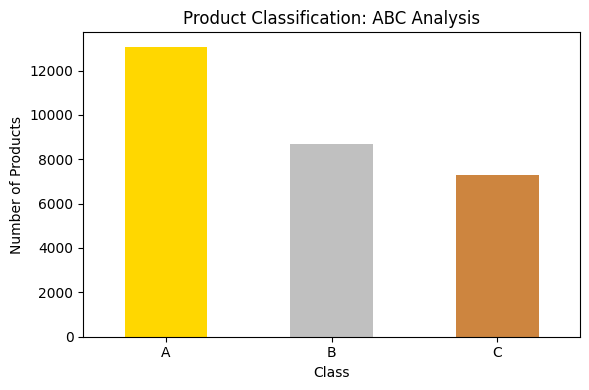

In [10]:
import matplotlib.pyplot as plt

# Count number of products per class
abc_counts = df_revenue["class"].value_counts().sort_index()
print("ABC counts:\n", abc_counts)

# Show sample stats for 5 products from each class
for cls in ["A", "B", "C"]:
    print(f"\nClass {cls} Products:")
    display(
        df_revenue[df_revenue["class"] == cls][
            ["product_id", "total_revenue", "cumulative_percentage"]
        ].head(5)
    )

# Plot distribution with valid colors
plt.figure(figsize=(6,4))
abc_counts.plot(kind="bar", color=["gold", "silver", "peru"])  # 'peru' replaces invalid 'bronze'
plt.title("Product Classification: ABC Analysis")
plt.xlabel("Class")
plt.ylabel("Number of Products")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


ABC Analysis – Wrap-Up

Here's the takeaway:

Class A products (13,069 items) are the crown jewels 💎—they contribute the lion's share of revenue and should get premium attention in procurement and stocking.

Class B (8,703 items) sit in the mid-zone—they’re steady earners, great for backup inventory and strategic bundles.

Class C (7,274 items) are low-impact outliers—ripe for phase-out, consolidation, or creative repurposing.

🔍 ABC classification simplifies decision-making by showing where the money’s coming from—and where it isn’t.

Analysis 3: Delivery Timeliness Assessment
Objective: Score each supplier on how quickly they deliver after shipment—looking for delays, consistency, and speed benchmarks.

Aggregate Timeliness Metrics by Supplier
Let’s group the data and extract time-based stats for each supplier_id.

Loads your data

Merges order items with inventory

Calculates delivery duration

Summarizes delivery metrics (without supplier breakdown for now)

In [11]:
import pandas as pd

# Load datasets
df_order_items = pd.read_csv("order_items.csv")
df_inventory = pd.read_csv("inventory_items.csv")

# Merge order items with inventory to get product_category
df_merged = pd.merge(
    df_order_items,
    df_inventory[["inventory_items_id", "product_category"]],
    left_on="inventory_item_id",
    right_on="inventory_items_id",
    how="left"
)

# Convert timestamps
df_merged["shipped_at"] = pd.to_datetime(df_merged["shipped_at"], errors="coerce")
df_merged["delivered_at"] = pd.to_datetime(df_merged["delivered_at"], errors="coerce")

# Calculate delivery duration
df_merged["delivery_days"] = (df_merged["delivered_at"] - df_merged["shipped_at"]).dt.days
df_merged = df_merged[df_merged["delivery_days"] >= 0]  # Filter out invalids

# Overall delivery summary
overall_summary = df_merged["delivery_days"].agg(
    average_days="mean",
    median_days="median",
    max_days="max",
    min_days="min",
    count="count"
).round(2)

# Category-level delivery summary
category_summary = (
    df_merged.groupby("product_category")["delivery_days"]
    .agg(
        average_days="mean",
        median_days="median",
        max_days="max",
        min_days="min",
        count="count"
    )
    .round(2)
    .sort_values("average_days")
)

# Display results
print("📦 Overall Delivery Time Summary:")
print(overall_summary)
print("\n📊 Delivery Time by Product Category:")
print(category_summary)


📦 Overall Delivery Time Summary:
average_days        2.01
median_days         2.00
max_days            4.00
min_days            0.00
count           62286.00
Name: delivery_days, dtype: float64

📊 Delivery Time by Product Category:
                               average_days  median_days  max_days  min_days  \
product_category                                                               
Clothing Sets                          1.81          1.0       4.0       0.0   
Fashion Hoodies & Sweatshirts          1.97          2.0       4.0       0.0   
Blazers & Jackets                      1.98          2.0       4.0       0.0   
Sweaters                               1.98          2.0       4.0       0.0   
Intimates                              1.99          2.0       4.0       0.0   
Leggings                               1.99          2.0       4.0       0.0   
Shorts                                 1.99          2.0       4.0       0.0   
Dresses                                1.99     

### 📦 Delivery Timeliness by Product Category

- Analyzed ~62K transactions to assess delivery duration (shipped → delivered).
- Merged order data with inventory metadata to assign `product_category`.
- **Overall average delivery time**: **2.01 days**; **median**: **2.00 days**.
- **Category-level averages** range from **1.81 to 2.07 days**.
  - Fastest: *Clothing Sets*, *Fashion Hoodies & Sweatshirts*.
  - Slowest: *Maternity*, *Jumpsuits & Rompers*.
- **Median and max delivery times** are consistent across categories.
- Variation in averages suggests occasional delays in specific categories.
- Insight supports category-level supply chain tuning (e.g., vendor SLAs, inventory planning).

Analysis 4

In [13]:
import pandas as pd

# Load the dataset
df_order_items = pd.read_csv("order_items.csv")

# Convert timestamps using format='mixed' to handle ISO 8601 with microseconds and timezone
df_order_items["created_at"] = pd.to_datetime(df_order_items["created_at"], format="mixed")
df_order_items["shipped_at"] = pd.to_datetime(df_order_items["shipped_at"], format="mixed")

print("✅ Timestamps successfully converted using mixed format.")


✅ Timestamps successfully converted using mixed format.


Calculate Order Processing Time
We’ll compute the time difference between shipped_at and created_at for each order item, then calculate the average across all rows.

In [14]:
# Calculate processing time in hours
df_order_items["processing_time_hours"] = (df_order_items["shipped_at"] - df_order_items["created_at"]).dt.total_seconds() / 3600

# Drop rows with missing or negative processing times (if any)
df_valid = df_order_items[df_order_items["processing_time_hours"] > 0]

# Compute the enterprise-wide average
average_processing_time = df_valid["processing_time_hours"].mean()

print(f"🏁 Enterprise-Wide Average Order Processing Time: {average_processing_time:.2f} hours")


🏁 Enterprise-Wide Average Order Processing Time: 34.94 hours


## 📦 Enterprise-Wide Order Processing Time Analysis

**Average Processing Time:**  
Approximately **34.94 hours** from order placement (`created_at`) to shipment (`shipped_at`).

---

### 🔍 Key Insights

- **Metric Purpose:** Measures internal order fulfillment speed before carrier involvement.
- **Operational Impact:**  
  - Reflects efficiency of warehouse and order management systems  
  - Influences inventory turnover and customer satisfaction  
  - Identifies opportunities for automation and workflow optimization

---

### 🛠️ Supply Chain & Procurement Applications

- **Lead Time Management:** Informs supplier SLAs and procurement planning  
- **Inventory Strategy:** Supports lean inventory and just-in-time models  
- **Continuous Improvement:** Enables data-driven decisions to reduce delays and streamline operations